<a href="https://colab.research.google.com/github/unicamp-dl/IA025_2022S1/blob/main/ex02/larissa_santesso/Aula_2_Exerc%C3%ADcio_Larissa_Santesso.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notebook de referência 

Nome: Larissa Antonelli Santesso

## Instruções

Este exercício consiste em escrever um código para treinar um modelo linear usando SGD e vizualizar como a função de perda varia em função das pesos da rede.

A implementação será considerada correta apenas se passar nos 3 asserts ao longo deste notebook.

## Problema de Regressão Linear

O problema de ajuste de uma reta a um conjunto de pontos para verificar se existe uma previsão linear é um problema muito antigo, muito estudado e muito presente nos dias de hoje. 

Quando o ajuste é abordado como um problema de **otimização numérica**, ele é a base de boa parte dos **conceitos sobre redes neurais** e iremos explorá-lo aqui como uma forma de introdução às redes neurais. O modelo de regressão linear que iremos utilizar pode
ser visto como uma rede neural de apenas uma camada e função de ativação linear.

## Conjunto de dados: Flores Íris

Iremos utilizar duas propriedades do conjunto de dados das flores Íris [Wikipedia-Iris_flower_data_set](https://en.wikipedia.org/wiki/Iris_flower_data_set):

* o comprimento das sépalas e 
* o comprimento da pétalas. 

A ideia será prever o comprimento da pétala, conhecendo-se o comprimento da sépala. Estaremos usando apenas uma propriedade, ou característica ou *feature* do objeto para que seja fácil visualizar o espaço de busca de parâmetros. 

Vamos utilizar as 50 amostras da variedade versicolor.

![](https://raw.githubusercontent.com/robertoalotufo/files/master/figures/iris_petals_sepals.png)

## Dados: leitura e visualização


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython import display

import numpy as np
import pandas as pd
from sklearn.datasets import load_iris
import time

In [2]:
iris = load_iris()
data = iris.data[iris.target==1,::2]  # comprimento das sépalas e pétalas, indices 0 e 2

x_in = data[:,0:1]
y_in = data[:,1:2]
iris_pd = pd.DataFrame(x_in, columns=['x_in'])
iris_pd['y_in'] = y_in
iris_pd.head()

,x_in,y_in
0,7.0,4.7
1,6.4,4.5
2,6.9,4.9
3,5.5,4.0
4,6.5,4.6


## Visualização dos dados `x_in` e `y_in` e normalizados

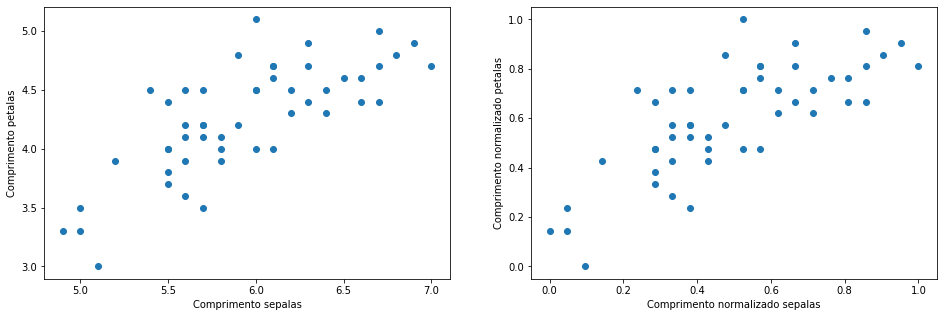

In [3]:
x = x_in - x_in.min()
x /= x.max()    # normalização
y = y_in - y_in.min()
y /= y.max()

fig = plt.figure(figsize=(16,5))
ax_in = fig.add_subplot(1,2,1)
ax_in.scatter(x_in, y_in)
ax_in.set_xlabel('Comprimento sepalas')
ax_in.set_ylabel('Comprimento petalas')
ax_n = fig.add_subplot(1,2,2)
ax_n.scatter(x, y)
ax_n.set_xlabel('Comprimento normalizado sepalas')
ax_n.set_ylabel('Comprimento normalizado petalas');

## Reta de ajuste

A equação da reta no plano necessita de dois parâmetros, aqui denominados $w_0$ (*bias*) e inclinação $w_1$. Veja figura:


<img src="https://raw.githubusercontent.com/robertoalotufo/files/master/figures/linhareta.png" width="300pt">

A reta de ajuste será dada por:

$$ \hat{y} = w_0 + w_1 x $$

onde 
* $w_1$ é o coeficiente angular da reta e 
* $w_0$ é a interseção do eixo vertical quando x é igual a zero, também denominado de *bias*.
* $x$ é a variável de entrada (comprimento das sépalas) e 
* $\hat{y}$ é a predição (comprimento estimado das pétalas).

## Representação gráfica da equação linear via neurônio

$ \hat{y} = 1 w_0 + x_0 w_1 $

Temos:
- 1 atributo de entrada: $x_0$
- 2 parâmetros para serem ajustados (treinados) $w_0$ e $w_1$
- 1 classe de saída $\hat{y}$

<img src="https://raw.githubusercontent.com/robertoalotufo/files/master/figures/RegressaoLinearNeuronio.png" width="300pt">
$$ \hat{y} = w_0 + w_1 x $$
$$ \mathbf{\hat{y}} = \mathbf{w} \mathbf{x} $$

### Função Custo ou de Perda (MSE - Mean Square Error)

<img src="https://raw.githubusercontent.com/robertoalotufo/files/master//figures/Loss_MSE.png" width = "600pt">


A função de custo depende do conjunto de treinamento ($y_i$) e dos valores de predição ($\hat{y_i}$):

$$ J(\hat{y_i},y_i) = \frac{1}{M} \sum_{i=0}^{M-1} (\hat{y_i} - y_i)^2 $$ .


## Laço de minimização via gradiente descendente

O código da próxima célula é a parte principal deste notebook. É aqui que a minimização é feita. É aqui que dizemos que estamos fazendo o *fit*, ou o treinamento do sistema para encontrar o parâmetro $\mathbf{W}$ que minimiza a função de perda $J$. Acompanhamos a convergência da minimização pelo valor da perda a cada iteração, plotando o vetor `J_history`.

O esquema da otimização é representado pelo diagrama a seguir:

<img src="https://raw.githubusercontent.com/robertoalotufo/files/master/figures/RegressaoLinear_Otimizacao.png" width = "600pt">

e é implementado pela próxima célula de código:

## Funções: Custo, Gradiente Descendente

In [4]:
# É importante fixar as seeds para passar nos asserts abaixo.

import random
import numpy as np

random.seed(123)
np.random.seed(123)

In [5]:
import torch
from torch import nn, optim

torch.manual_seed(123)

In [6]:
class Model():
    def __init__(self, n_in: int, n_out: int):
        self.weight = torch.zeros(n_out,n_in, requires_grad=True)
    
    def forward(self, x):
        y_pred = x.mm(torch.t(self.weight))
        return y_pred

In [7]:
# Testando uma maneira de pegar mini batches (fonte)
X = torch.Tensor(x)
Y = torch.Tensor(y)
permutation = torch.randperm(X.size()[0])
print(f"Permutation = {permutation}")
batch_size = 10
for i in range(0,X.size()[0], batch_size):

    indices = permutation[i:i+batch_size]
    print(f"indices: {indices}")
    batch_x, batch_y = X[indices], Y[indices]
    print(f"batch_x, batch_y = {torch.cat((batch_x, batch_y),1)}")

# fonte: https://stackoverflow.com/questions/45113245/how-to-get-mini-batches-in-pytorch-in-a-clean-and-efficient-way

Permutation = tensor([32, 30,  0, 16, 24, 37,  3, 41, 13, 12, 21, 15, 18,  5, 42, 49, 28, 23,
        27,  9,  1, 10, 29, 17, 11, 19, 47, 36, 46, 22,  6,  8,  7, 34, 25, 33,
        31, 48, 14, 38, 44,  2, 39, 40,  4, 20, 45, 43, 35, 26])
indices: tensor([32, 30,  0, 16, 24, 37,  3, 41, 13, 12])
batch_x, batch_y = tensor([[0.4286, 0.4286],
        [0.2857, 0.3810],
        [1.0000, 0.8095],
        [0.3333, 0.7143],
        [0.7143, 0.6190],
        [0.6667, 0.6667],
        [0.2857, 0.4762],
        [0.5714, 0.7619],
        [0.5714, 0.8095],
        [0.5238, 0.4762]])
indices: tensor([21, 15, 18,  5, 42, 49, 28, 23, 27,  9])
batch_x, batch_y = tensor([[0.5714, 0.4762],
        [0.8571, 0.6667],
        [0.6190, 0.7143],
        [0.3810, 0.7143],
        [0.4286, 0.4762],
        [0.3810, 0.5238],
        [0.5238, 0.7143],
        [0.5714, 0.8095],
        [0.8571, 0.9524],
        [0.1429, 0.4286]])
indices: tensor([ 1, 10, 29, 17, 11, 19, 47, 36, 46, 22])
batch_x, batch_y = tensor([

In [8]:
def train(model, x, y, learning_rate: float, n_epochs: int):
    """Train a linear model with SGD.

    Returns:
        loss_history: a np.array of shape (n_epochs,)
        w_history: a np.array of shape (n_epochs, 2)
    """
    # inicializando listas
    loss_history = []
    w_history = []

    # criando vetor x com bias
    x_train_bias = torch.cat([torch.ones(size=(len(x),1)), torch.Tensor(x)], dim=1)

    # transformando para torch x_bias e y
    x_bias_torch = torch.Tensor(x_train_bias)
    y_torch = torch.Tensor(y)

    # definindo tamanho do batch
    batch_size = 50

    # loss utilizada: MSE
    criterion = nn.MSELoss()

    for epoch in range(n_epochs):
        # criando tensor com númeor de índices aleatórios com tamanho do dataset de treino (50)
        permutation = torch.randperm(x_bias_torch.size()[0])
        
        # salvando os pesos em uma lista
        w_history.extend(model.weight.detach().numpy())

        # pegando os índices randômicos a cada batch_size e aplicando em x,y
        for i in range(0,x_bias_torch.size()[0], batch_size):
            indices = permutation[i:i+batch_size]
            batch_x, batch_y = x_bias_torch[indices], y_torch[indices]

            inputs = batch_x
            target = batch_y

            # saída do modelo
            out = model.forward(inputs)

            #loss cálculo da função de perda
            loss = criterion(out, target)

            if model.weight.grad: model.weight.grad.zero_()
            loss.backward()

            # cálculo do gradiente
            w_grad = model.weight.grad

            # gradiente descendente
            with torch.no_grad(): model.weight = model.weight - learning_rate * w_grad
            model.weight.requires_grad_()

        # salvando a loss em uma lista
        loss_history.append(loss.detach().numpy())

        # imprimindo valores da loss a cada época
        if (epoch+1) % 1 == 0:
            print('Epoch[{}/{}], loss: {:.6f}'
                .format(epoch+1, n_epochs, loss.item()))

    # salvando a última loss e os últimos pesos na lista
    out = model.forward(inputs)
    loss = criterion(out, target)
    loss_history.append(loss.detach().numpy())
    w_history.extend(model.weight.detach().numpy())

    # convertendo para um array float64
    loss_history = np.array(loss_history,dtype=np.float64)
    w_history = np.array(w_history, dtype=np.float64)

    return loss_history, w_history

### Testando as funções

In [9]:
model = Model(2, 1) # duas entradas (1 + x0) e uma saída y_pred
loss_history, w_history = train(model=model, x=x, y=y, learning_rate=0.5, n_epochs=20)

Epoch[1/20], loss: 0.409070
Epoch[2/20], loss: 0.055997
Epoch[3/20], loss: 0.032085
Epoch[4/20], loss: 0.029729
Epoch[5/20], loss: 0.028853
Epoch[6/20], loss: 0.028139
Epoch[7/20], loss: 0.027497
Epoch[8/20], loss: 0.026914
Epoch[9/20], loss: 0.026385
Epoch[10/20], loss: 0.025905
Epoch[11/20], loss: 0.025469
Epoch[12/20], loss: 0.025073
Epoch[13/20], loss: 0.024713
Epoch[14/20], loss: 0.024387
Epoch[15/20], loss: 0.024090
Epoch[16/20], loss: 0.023821
Epoch[17/20], loss: 0.023577
Epoch[18/20], loss: 0.023355
Epoch[19/20], loss: 0.023154
Epoch[20/20], loss: 0.022971


In [10]:
w_history

array([[0.        , 0.        ],
       [0.60000002, 0.33664399],
       [0.43392229, 0.27542454],
       [0.4641239 , 0.31466085],
       [0.44476733, 0.3271254 ],
       [0.43861815, 0.34536761],
       [0.42961866, 0.36112359],
       [0.4218457 , 0.37655178],
       [0.41423446, 0.3911463 ],
       [0.40703452, 0.4050796 ],
       [0.40016073, 0.41834888],
       [0.39361456, 0.43099412],
       [0.38737625, 0.44304258],
       [0.38143232, 0.45452291],
       [0.37576869, 0.46546179],
       [0.37037218, 0.4758848 ],
       [0.36523017, 0.48581624],
       [0.36033067, 0.49527928],
       [0.35566223, 0.50429606],
       [0.35121396, 0.5128876 ],
       [0.34697545, 0.52107394]])

In [11]:
loss_history

array([0.40907028, 0.05599691, 0.03208511, 0.02972902, 0.02885257,
       0.02813922, 0.02749694, 0.02691416, 0.02638508, 0.02590473,
       0.02546862, 0.02507267, 0.02471319, 0.02438681, 0.0240905 ,
       0.02382147, 0.02357722, 0.02335547, 0.02315414, 0.02297135,
       0.02280539])

In [12]:
# Assert do histórico de losses
target_loss_history = np.array(
    [0.40907029, 0.0559969 , 0.03208511, 0.02972902, 0.02885257,
     0.02813922, 0.02749694, 0.02691416, 0.02638508, 0.02590473,
     0.02546862, 0.02507267, 0.02471319, 0.02438681, 0.0240905 ,
     0.02382147, 0.02357722, 0.02335547, 0.02315414, 0.02297135,
     0.0228054])

assert np.allclose(loss_history, target_loss_history, atol=1e-6)

In [13]:
# Assert de histórico de pesos da rede
target_w_history = np.array(
    [[0.,         0.        ],
    [0.6,        0.336644  ],
    [0.4339223,  0.27542454],
    [0.4641239,  0.31466085],
    [0.44476733, 0.3271254 ],
    [0.43861815, 0.3453676 ],
    [0.42961866, 0.3611236 ],
    [0.4218457,  0.37655178],
    [0.41423446, 0.3911463 ],
    [0.40703452, 0.4050796 ],
    [0.40016073, 0.41834888],
    [0.39361456, 0.43099412],
    [0.38737625, 0.44304258],
    [0.38143232, 0.4545229 ],
    [0.3757687,  0.4654618 ],
    [0.37037218, 0.4758848 ],
    [0.36523017, 0.48581624],
    [0.36033067, 0.49527928],
    [0.35566223, 0.50429606],
    [0.35121396, 0.5128876 ],
    [0.34697545, 0.52107394]])

assert np.allclose(w_history, target_w_history, atol=1e-6)

# Função de cálculo do grid de custos

In [14]:
def compute_loss_grid(x, y, w_0_grid, w_1_grid):
    """Returns:
        loss_grid: an array with the same shape of w_0_grid (or w_1_grid). 
    """

    # Criando um meshgrid de w0 e w1 (cada combinação será avaliada)
    w0, w1  = np.meshgrid(w_0_grid, w_1_grid) # w0 e w1 - shape [100, 100]

    # Ajustando as dimensões do w0, w1 e da entrada e saída (x e y) para realizar o cálculo matricialmente
    w0 = np.expand_dims(w0, axis=-1) # shape [100, 100, 1]
    print(f"w0: {w0.shape}")
    w1 = np.expand_dims(w1, axis=-1) # shape [100, 100, 1]
    print(f"w1: {w1.shape}")
    xt = x.reshape(1,1,-1) # shape [1, 1, 50]
    print(f"x (reshape): {xt.shape}")
    yt = y.reshape(1,1,-1) # shape [1, 1, 50]
    print(f"y (reshape): {yt.shape}")

    # Cálculo do y predito para cada combinação de w0,w1
    # com a terceira dimensão contendo o valor predito para cada amostra.
    ypred = w0 + w1*xt # ypred shape [100, 100, 50]
    print(f"ypred: {ypred.shape}")

    # Cálculo da loss avaliada entre ypred e yt
    loss = np.square(ypred-yt)  # loss shape [100, 100, 50]
    print(f"loss: {loss.shape}")
    # Calculando a média de cada loss entre todas as amostras 
    # (a terceira dimensão irá sumir nessa etapa)
    loss_grid = loss.mean(axis=2) # loss_grid shape [100, 100]
    print(f"loss_grid: {loss_grid.shape}")
    return loss_grid

In [15]:
wmin = w_history.min(axis=0)
wmax = w_history.max(axis=0)
D = wmax - wmin
wmin -= D
wmax += D

w_0_grid = np.linspace(wmin[0], wmax[0], 100)
w_1_grid = np.linspace(wmin[1], wmax[1], 100)

loss_grid = compute_loss_grid(x, y, w_0_grid, w_1_grid)

w0: (100, 100, 1)
w1: (100, 100, 1)
x (reshape): (1, 1, 50)
y (reshape): (1, 1, 50)
ypred: (100, 100, 50)
loss: (100, 100, 50)
loss_grid: (100, 100)


### Testando a função

In [16]:
!gsutil cp gs://unicamp-dl/ia025a_2022s1/aula2/target_loss_grid.npy .
target_loss_grid = np.load('target_loss_grid.npy')

Copying gs://unicamp-dl/ia025a_2022s1/aula2/target_loss_grid.npy...
/ [1 files][ 78.2 KiB/ 78.2 KiB]                                                
Operation completed over 1 objects/78.2 KiB.                                     


In [17]:
assert np.allclose(loss_grid, target_loss_grid, atol=1e-6) 

## Funcão de Plot

In [18]:
def show_plots(x, y, w_0_grid, w_1_grid, loss_grid, loss_history, w_history, sleep=0.3):
    n_samples = y.shape[0]

    # valor ótimo, solução analítica
    # ------------------------------
    x_bias = np.hstack([np.ones((n_samples, 1)), x])
    w_opt = (np.linalg.inv((x_bias.T).dot(x_bias)).dot(x_bias.T)).dot(y)    
    x_all = np.linspace(x.min(), x.max(), 100).reshape(100, 1)
    x_all_bias = np.hstack([np.ones((100, 1)), x_all])
    result_opt = x_all_bias.dot(w_opt)    # Predição do valor ótimo
        
    # Gráficos:
    # --------
    fig = plt.figure(figsize=(18, 6))
    ax_grid = fig.add_subplot(1, 3, 1)    # Grid de losses
    ax_loss = fig.add_subplot(1, 3, 2)    # Função perda

    ax_loss.plot(loss_history)
    ax_loss.set_title('Perda', fontsize=15)
    ax_loss.set_xlabel('epochs', fontsize=10)
    ax_loss.set_ylabel('MSE', fontsize=10)

    ax_grid.pcolormesh(w_0_grid, w_1_grid, loss_grid, cmap=plt.cm.coolwarm)
    ax_grid.contour(w_0_grid, w_1_grid, loss_grid, 20)
    ax_grid.scatter(w_opt[0], w_opt[1], marker='x', c='w')  # Solução analítica.
    ax_grid.set_title('W', fontsize=15)
    ax_grid.set_xlabel('w0', fontsize=10)
    ax_grid.set_ylabel('w1', fontsize=10)

    # Plot dinâmico
    # -------------
    for i, (loss, w) in enumerate(zip(loss_history, w_history)):
        ax_loss.scatter(i, loss)
                            
        ax_grid.scatter(w[0], w[1], c='r', marker='o')
        
        display.display(fig)
        display.clear_output(wait=True)
        time.sleep(sleep)


## Plotagem iterativa do gradiente descendente, reta ajuste, parâmetros, função perda

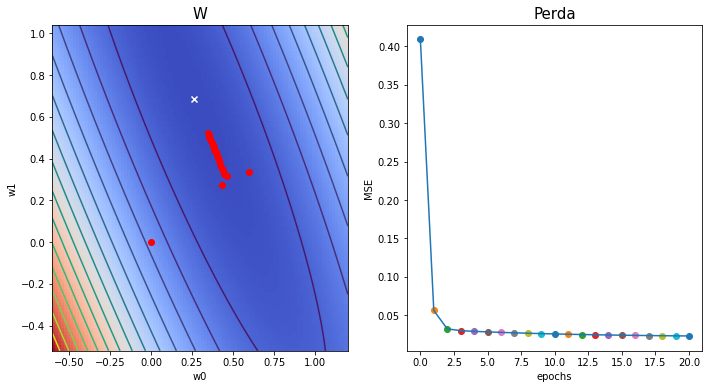

In [19]:
%matplotlib inline
try:
    show_plots(x, y, w_0_grid, w_1_grid, loss_grid, loss_history, w_history, sleep=0.01)
except KeyboardInterrupt:
    pass

# Exercício Extra

## Resultado original

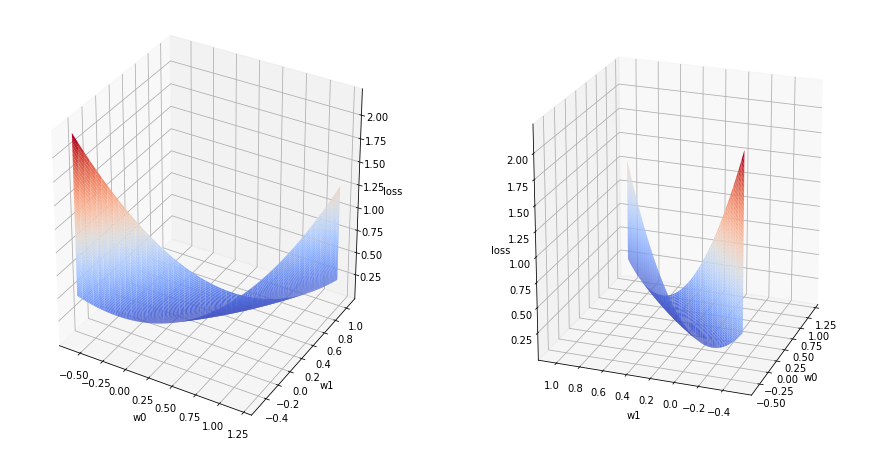

In [20]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

# original 
fig = plt.figure(figsize=(24, 8))
ax_grid1 = fig.add_subplot(1, 3, 1, projection='3d')
ax_grid2 = fig.add_subplot(1, 3, 2, projection='3d')

surface = ax_grid1.plot_surface(w_0_grid, w_1_grid, loss_grid, cmap=cm.coolwarm)
# Set some labels
ax_grid1.set_xlabel('w0')
ax_grid1.set_ylabel('w1')
ax_grid1.set_zlabel('loss')

surface = ax_grid2.plot_surface(w_0_grid, w_1_grid, loss_grid, cmap=cm.coolwarm)
# Set some labels
ax_grid2.set_xlabel('w0')
ax_grid2.set_ylabel('w1')
ax_grid2.set_zlabel('loss')
ax_grid2.view_init(20, 200)

plt.show()

## Utilizando vetores ortogonais não randômicos:

In [21]:
alpha_nr = np.linspace(-10,10,100).reshape(1,-1)
beta_nr = np.linspace(-10,10,100).reshape(1,-1)

delta_nr = np.array([1,0]).reshape(2,1)
eta_nr =  np.array([0,1]).reshape(2,1)

theta_ast = w_history[-1].reshape(2,1)

w_nr = theta_ast + alpha_nr*delta_nr + beta_nr*eta_nr
w_nr.shape

(2, 100)

In [22]:
# Confirmando que são vetores ortogonais: produto interno = 0
np.dot(delta_nr.squeeze(), eta_nr.squeeze())

0

w0: (100, 100, 1)
w1: (100, 100, 1)
x (reshape): (1, 1, 50)
y (reshape): (1, 1, 50)
ypred: (100, 100, 50)
loss: (100, 100, 50)
loss_grid: (100, 100)


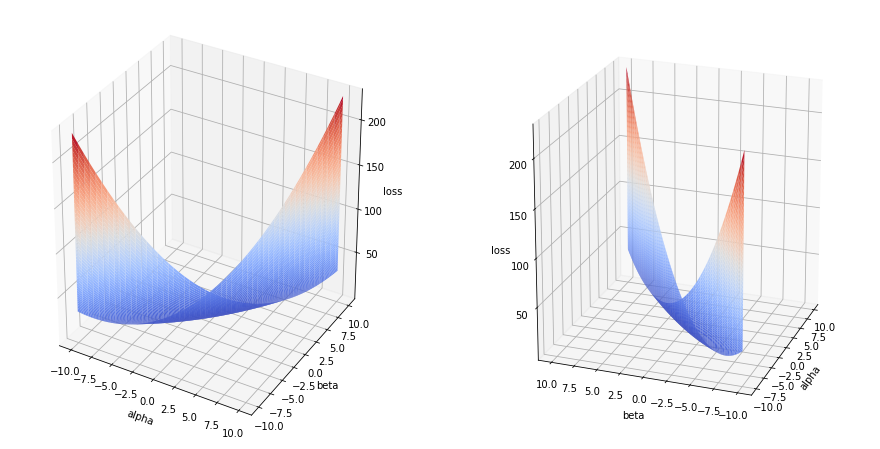

In [23]:
loss_grid2 = compute_loss_grid(x, y, w_nr[0], w_nr[1])

fig = plt.figure(figsize=(24, 8))
ax_grid1 = fig.add_subplot(1, 3, 1, projection='3d')
ax_grid2 = fig.add_subplot(1, 3, 2, projection='3d')

surface = ax_grid1.plot_surface(alpha_nr, beta_nr, loss_grid2, cmap=cm.coolwarm)
# Set some labels
ax_grid1.set_xlabel('alpha')
ax_grid1.set_ylabel('beta')
ax_grid1.set_zlabel('loss')

surface = ax_grid2.plot_surface(alpha_nr, beta_nr, loss_grid2, cmap=cm.coolwarm)
# Set some labels
ax_grid2.set_xlabel('alpha')
ax_grid2.set_ylabel('beta')
ax_grid2.set_zlabel('loss')
ax_grid2.view_init(20, 200)

plt.show()

## Utilizando vetores randômicos ortogonais:

In [24]:
alpha = np.linspace(-10,10,100).reshape(1,-1)
beta = np.linspace(-10,10,100).reshape(1,-1)

delta = np.random.uniform(0,1,2).reshape(2,1)
delta /= np.linalg.norm(delta)

eta0 = np.random.uniform(0,1)
#encontrando segundo elemento que o produto intertno resulte em zero
# delta[0]*eta[0] + delta[1]*eta[1] = 0
eta1 = -delta[0]*eta0/delta[1] 
eta = np.array([eta0, eta1[0]])
eta /= np.linalg.norm(eta)
eta = eta.reshape(2,1)

theta_ast = w_history[-1].reshape(2,1)

w = theta_ast + alpha*delta + beta*eta
w.shape

(2, 100)

In [25]:
# Confirmando que são vetores ortogonais: produto interno = 0
np.dot(delta.squeeze(), eta.squeeze())

0.0

In [26]:
w

array([[-12.70301049, -12.43937441, -12.17573833, -11.91210225,
        -11.64846617, -11.38483009, -11.12119401, -10.85755793,
        -10.59392185, -10.33028577, -10.06664969,  -9.80301361,
         -9.53937753,  -9.27574145,  -9.01210538,  -8.7484693 ,
         -8.48483322,  -8.22119714,  -7.95756106,  -7.69392498,
         -7.4302889 ,  -7.16665282,  -6.90301674,  -6.63938066,
         -6.37574458,  -6.1121085 ,  -5.84847242,  -5.58483634,
         -5.32120026,  -5.05756418,  -4.7939281 ,  -4.53029202,
         -4.26665594,  -4.00301987,  -3.73938379,  -3.47574771,
         -3.21211163,  -2.94847555,  -2.68483947,  -2.42120339,
         -2.15756731,  -1.89393123,  -1.63029515,  -1.36665907,
         -1.10302299,  -0.83938691,  -0.57575083,  -0.31211475,
         -0.04847867,   0.21515741,   0.47879349,   0.74242956,
          1.00606564,   1.26970172,   1.5333378 ,   1.79697388,
          2.06060996,   2.32424604,   2.58788212,   2.8515182 ,
          3.11515428,   3.37879036,   3.

w0: (100, 100, 1)
w1: (100, 100, 1)
x (reshape): (1, 1, 50)
y (reshape): (1, 1, 50)
ypred: (100, 100, 50)
loss: (100, 100, 50)
loss_grid: (100, 100)


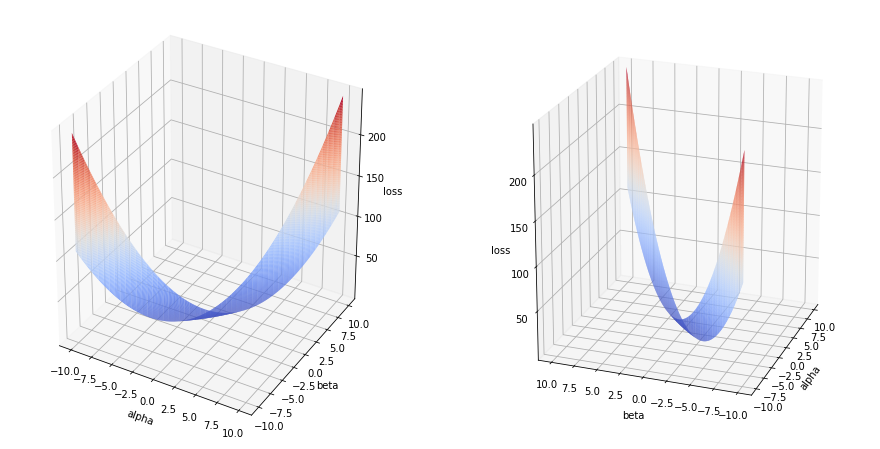

In [27]:
loss_grid3 = compute_loss_grid(x, y, w[0], w[1])

fig = plt.figure(figsize=(24, 8))
ax_grid1 = fig.add_subplot(1, 3, 1, projection='3d')
ax_grid2 = fig.add_subplot(1, 3, 2, projection='3d')

surface = ax_grid1.plot_surface(alpha, beta, loss_grid3, cmap=cm.coolwarm)
# Set some labels
ax_grid1.set_xlabel('alpha')
ax_grid1.set_ylabel('beta')
ax_grid1.set_zlabel('loss')

surface = ax_grid2.plot_surface(alpha, beta, loss_grid3, cmap=cm.coolwarm)
# Set some labels
ax_grid2.set_xlabel('alpha')
ax_grid2.set_ylabel('beta')
ax_grid2.set_zlabel('loss')
ax_grid2.view_init(20, 200)

plt.show()

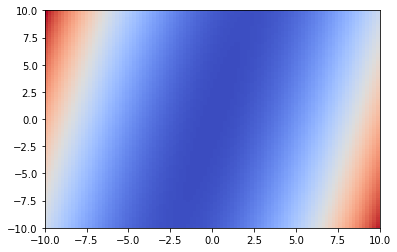

In [28]:
plt.pcolormesh(alpha.squeeze(), beta.squeeze(), loss_grid3, cmap=plt.cm.coolwarm)